In [1]:
#!pip install opencv-contrib-python

In [2]:
#!pip install Pillow

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2
#from google.colab.patches import cv2_imshow
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch import optim

from PIL import Image
import shutil
import glob
import re

from tqdm import tqdm

In [4]:
if os.path.exists("./train_aug") == True:
    shutil.rmtree("./train_aug")
if os.path.exists("./train_orig") == True:
    shutil.rmtree("./train_orig")

In [5]:
BASE_PATH = '.'

In [6]:
shutil.copytree(f"{BASE_PATH}/train", f"{BASE_PATH}/train_orig")
shutil.copytree(f"{BASE_PATH}/train", f"{BASE_PATH}/train_aug")

'./train_aug'

In [7]:
!nvidia-smi

Sun May 29 20:25:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:0B:00.0  On |                  N/A |
| 38%   54C    P8    23W / 370W |  13001MiB / 24576MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:0C:00.0 Off |                  N/A |
|  0%   

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
'''
gpu_ids = [0, 1]
if torch.cuda.is_available():
    device = torch.device(f'cuda:{gpu_ids[0]}')
else:
    device = torch.device('cpu')
'''
print(device)

cuda:0


In [9]:
train_df = pd.read_csv(f'{BASE_PATH}/train_master.tsv', sep='\t')

In [10]:
train_df

,id,userid,pose,expression,eyes
0,train_0000.jpg,choon,straight,angry,open
1,train_0001.jpg,kk49,straight,angry,open
2,train_0002.jpg,phoebe,right,sad,sunglasses
3,train_0003.jpg,kawamura,left,neutral,sunglasses
4,train_0004.jpg,an2i,left,happy,sunglasses
...,...,...,...,...,...
307,train_0307.jpg,karyadi,straight,neutral,open
308,train_0308.jpg,kk49,straight,neutral,open
309,train_0309.jpg,karyadi,left,neutral,sunglasses
310,train_0310.jpg,at33,left,happy,open


In [11]:
# label-encoding
# 1.userid
for i, name in enumerate(train_df.userid.value_counts().index.tolist()):
    train_df.replace({"userid":{name:i}}, inplace=True)
# 2.pose
train_df.replace({"pose":{"up":0,"straight":1,"left":2,"right":3}}, inplace=True)
# 3.expression
train_df.replace({"expression":{"sad":0,"angry":1,"neutral":2,"happy":3}}, inplace=True)
# 4.eyes
train_df.replace({"eyes":{"sunglasses":0,"open":1}}, inplace=True)
train_df

,id,userid,pose,expression,eyes
0,train_0000.jpg,2,1,1,1
1,train_0001.jpg,11,1,1,1
2,train_0002.jpg,7,3,0,0
3,train_0003.jpg,0,2,2,0
4,train_0004.jpg,3,2,3,0
...,...,...,...,...,...
307,train_0307.jpg,14,1,2,1
308,train_0308.jpg,11,1,2,1
309,train_0309.jpg,14,2,2,0
310,train_0310.jpg,4,2,3,1


In [12]:
train_imgs = [] # 画像イメージを入れる箱

In [13]:
# フォルダ内のファイルの個数を返す
DIR = f'{BASE_PATH}/train/'
print(sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR)))
image_sum = sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR))

312


In [14]:
str(0).zfill(4)  # ファイル名は4桁の数字 0001 etc.

'0000'

In [15]:
# cv2.imread:カラー画像のファイルを読み込むと、行（高さ） x 列（幅） x 色（3）の三次元のndarrayとなる。
for i in range(image_sum):
    train_img = cv2.imread(f'{BASE_PATH}/train/train_{str(i).zfill(4)}.jpg')
    train_imgs.append(train_img)

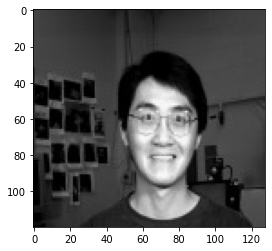

In [16]:
#cv2_imshow(train_imgs[0])
plt.imshow(train_imgs[0])

img = train_imgs[0] # モザイク
resize_img = cv2.resize(img,(img.shape[1] // 10, img.shape[0] // 10))
plt.imshow(resize_img)
resize_img.shape

In [17]:
## Data Augmentation

In [18]:
#!mkdir train_aug
# os.mkdir("./train_aug")

In [19]:
for i in range(len(train_imgs)):
    img = train_imgs[i]
    flip_img1 = cv2.flip(img, 0)
    cv2.imwrite(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_flip1.jpg', flip_img1)
    
    flip_img2 = cv2.flip(img, 1)
    cv2.imwrite(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_flip2.jpg', flip_img2)
    
    flip_img3 = cv2.flip(img, -1)
    cv2.imwrite(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_flip3.jpg', flip_img3)
    
    mat = cv2.getRotationMatrix2D(tuple(np.array([img.shape[1] / 2, img.shape[0] /2])), 45, 1) #45度回転
    mat2 = cv2.getRotationMatrix2D(tuple(np.array([img.shape[1] / 2, img.shape[0] /2])), 315, 1) #45度回転
    rotation_img = cv2.warpAffine(img, mat, (img.shape[1], img.shape[0]))
    rotation_img2 = cv2.warpAffine(img, mat2, (img.shape[1], img.shape[0]))
    cv2.imwrite(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_rotate.jpg', rotation_img)
    cv2.imwrite(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_rotate2.jpg', rotation_img2)

In [20]:
train_imgs[0].shape # OpenCVのフォーマットは Height, Width, Channel の順. Pytorch は Channel, Height, Weidth を期待

(120, 128, 3)

In [21]:
train_aug_imgs = []

In [22]:
for i in range(image_sum):
    train_img = cv2.imread(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}.jpg')
    train_aug_imgs.append(train_img)
    
    train_img1 = cv2.imread(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_flip1.jpg')
    train_aug_imgs.append(train_img1)
    
    train_img2 = cv2.imread(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_flip2.jpg')
    train_aug_imgs.append(train_img2)
    
    train_img3 = cv2.imread(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_flip3.jpg')
    train_aug_imgs.append(train_img3)
    
    train_img4 = cv2.imread(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_rotate.jpg')
    train_aug_imgs.append(train_img4)
    
    train_img5 = cv2.imread(f'{BASE_PATH}/train_aug/train_{str(i).zfill(4)}_rotate2.jpg')
    train_aug_imgs.append(train_img5)

In [23]:
len(train_aug_imgs)

1872

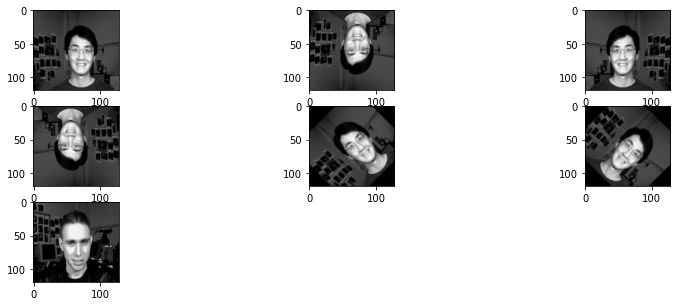

In [24]:
plt.figure(figsize=(14,5)) # グラフのサイズ(x,y)

plt.subplot(3,3,1)
plt.imshow(train_aug_imgs[0])

plt.subplot(3,3,2)
plt.imshow(train_aug_imgs[1])

plt.subplot(3,3,3)
plt.imshow(train_aug_imgs[2])

plt.subplot(3,3,4)
plt.imshow(train_aug_imgs[3])

plt.subplot(3,3,5)
plt.imshow(train_aug_imgs[4])

plt.subplot(3,3,6)
plt.imshow(train_aug_imgs[5])

plt.subplot(3,3,7)
plt.imshow(train_aug_imgs[6])

plt.show()

In [25]:
for i in range(len(train_aug_imgs)):
    train_aug_imgs[i] = train_aug_imgs[i].transpose(2,0,1)

In [26]:
def process_images(file_path):
    img =  torch.Tensor(file_path).float().to(device)
    return img

In [27]:
X = torch.Tensor(train_aug_imgs).float().to(device)

/tmp/ipykernel_6880/322310155.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755888534/work/torch/csrc/utils/tensor_new.cpp:210.)
  X = torch.Tensor(train_aug_imgs).float().to(device)


In [28]:
X.shape

torch.Size([1872, 3, 120, 128])

In [29]:
new_id = sorted(os.listdir('./train_aug'))
new_id

['train_0000.jpg',
 'train_0000_flip1.jpg',
 'train_0000_flip2.jpg',
 'train_0000_flip3.jpg',
 'train_0000_rotate.jpg',
 'train_0000_rotate2.jpg',
 'train_0001.jpg',
 'train_0001_flip1.jpg',
 'train_0001_flip2.jpg',
 'train_0001_flip3.jpg',
 'train_0001_rotate.jpg',
 'train_0001_rotate2.jpg',
 'train_0002.jpg',
 'train_0002_flip1.jpg',
 'train_0002_flip2.jpg',
 'train_0002_flip3.jpg',
 'train_0002_rotate.jpg',
 'train_0002_rotate2.jpg',
 'train_0003.jpg',
 'train_0003_flip1.jpg',
 'train_0003_flip2.jpg',
 'train_0003_flip3.jpg',
 'train_0003_rotate.jpg',
 'train_0003_rotate2.jpg',
 'train_0004.jpg',
 'train_0004_flip1.jpg',
 'train_0004_flip2.jpg',
 'train_0004_flip3.jpg',
 'train_0004_rotate.jpg',
 'train_0004_rotate2.jpg',
 'train_0005.jpg',
 'train_0005_flip1.jpg',
 'train_0005_flip2.jpg',
 'train_0005_flip3.jpg',
 'train_0005_rotate.jpg',
 'train_0005_rotate2.jpg',
 'train_0006.jpg',
 'train_0006_flip1.jpg',
 'train_0006_flip2.jpg',
 'train_0006_flip3.jpg',
 'train_0006_rotate.jpg'

In [30]:
new_df = pd.DataFrame(new_id)
new_df = new_df.rename(columns={0:'id'})

In [31]:
new_df = new_df[['id']]

In [32]:
len(new_df)

1872

In [33]:
for i in range(len(new_df)):
    j = i // 6
    new_df.loc[i, 'expression'] = train_df.loc[j, 'expression']

In [34]:
new_df.head(20)

,id,expression
0,train_0000.jpg,1.0
1,train_0000_flip1.jpg,1.0
2,train_0000_flip2.jpg,1.0
3,train_0000_flip3.jpg,1.0
4,train_0000_rotate.jpg,1.0
5,train_0000_rotate2.jpg,1.0
6,train_0001.jpg,1.0
7,train_0001_flip1.jpg,1.0
8,train_0001_flip2.jpg,1.0
9,train_0001_flip3.jpg,1.0


In [35]:
train_df

,id,userid,pose,expression,eyes
0,train_0000.jpg,2,1,1,1
1,train_0001.jpg,11,1,1,1
2,train_0002.jpg,7,3,0,0
3,train_0003.jpg,0,2,2,0
4,train_0004.jpg,3,2,3,0
...,...,...,...,...,...
307,train_0307.jpg,14,1,2,1
308,train_0308.jpg,11,1,2,1
309,train_0309.jpg,14,2,2,0
310,train_0310.jpg,4,2,3,1


In [36]:
y = torch.Tensor(new_df['expression'].to_numpy()).long().to(device) ## CrossEntropyLossで整数値で扱わなくてはならないためlong()型を指定

In [37]:
y.shape

torch.Size([1872])

In [38]:
y

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [39]:
#X = X / 255 # 画像データはRGB(0-255)の値をとるため、/255 で標準化(0-1の範囲に収めること)できる

In [40]:
#X[0]

In [41]:
#x_train, x_test, t_train, t_test = train_test_split(X, y, test_size=0.2, shuffle=False) 
# 4の倍数で分割したい
train_len = 936 # 312*3
x_train = X[:train_len]
t_train = y[:train_len] 
x_test = X[train_len:]
t_test = y[train_len:]

In [42]:
print(x_train.shape, x_test.shape, t_train.shape, t_test.shape)

torch.Size([936, 3, 120, 128]) torch.Size([936, 3, 120, 128]) torch.Size([936]) torch.Size([936])


In [43]:
t_train

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0,

In [44]:
train_df['expression'].value_counts()

0    83
1    78
2    77
3    74
Name: expression, dtype: int64

In [45]:
channel_num1 = 32
channel_num2 = 64  # maxpooling(2,2)後はchannelを2倍にする？
channel_num3 = 128

# nn.Linerに入れる次元を見るため前半のみを記載
models1 = nn.Sequential(
    nn.Conv2d(3, channel_num1, 3),  # 入力チャネル数, 出力チャネル数、カーネルサイズ
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_num1, channel_num1, 3),   # 入力チャネル数, 出力チャネル数、カーネルサイズ
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2),  # 縦横の画素数(2,2)が一般的
    nn.Dropout(p=0.2, inplace=True),
    nn.Conv2d(channel_num1, channel_num2, 3),  # 入力チャネル数, 出力チャネル数、カーネルサイズ
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_num2, channel_num2, 3),   # 入力チャネル数, 出力チャネル数、カーネルサイズ
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2),  # 縦横の画素数(2,2)が一般的
    nn.Dropout(p=0.3, inplace=True),
    nn.Conv2d(channel_num2, channel_num3, 3),  # 入力チャネル数, 出力チャネル数、カーネルサイズ
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_num3, channel_num3, 3),   # 入力チャネル数, 出力チャネル数、カーネルサイズ
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2),  # 縦横の画素数(2,2)が一般的
    nn.Dropout(p=0.4, inplace=True),
    nn.Flatten(), # 1階テンソルに変換
)

In [46]:
trial_input = torch.randn(1, 3, 120, 128) # 動作確認

In [47]:
flatten_size = models1(trial_input).shape[1]
flatten_size

16896

In [48]:
n_output = 4 # 0,1,2,3の4つに分類

In [49]:
# batcn normalization の定義。BatchNorm はそれ自身も関数を持っているため別々のインスタンスで定義が必要
bn1 = nn.BatchNorm2d(32)
bn2 = nn.BatchNorm2d(32)
bn3 = nn.BatchNorm2d(64)
bn4 = nn.BatchNorm2d(64)
bn5 = nn.BatchNorm2d(128)
bn6 = nn.BatchNorm2d(128)

In [50]:
model = nn.Sequential(
    nn.Conv2d(3, channel_num1, 3),  # 入力チャネル数, 出力チャネル数、カーネルサイズ
    bn1,
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_num1, channel_num1, 3),   # 入力チャネル数, 出力チャネル数、カーネルサイズ
    bn2,
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2),  # 縦横の画素数(2,2)が一般的
    nn.Dropout(p=0.2, inplace=True),
    nn.Conv2d(channel_num1, channel_num2, 3),  # 入力チャネル数, 出力チャネル数、カーネルサイズ
    bn3,
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_num2, channel_num2, 3),   # 入力チャネル数, 出力チャネル数、カーネルサイズ
    bn4,
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2),  # 縦横の画素数(2,2)が一般的
    nn.Dropout(p=0.3, inplace=True),
    nn.Conv2d(channel_num2, channel_num3, 3),  # 入力チャネル数, 出力チャネル数、カーネルサイズ
    bn5,
    nn.ReLU(inplace=True),
    nn.Conv2d(channel_num3, channel_num3, 3),   # 入力チャネル数, 出力チャネル数、カーネルサイズ
    bn6,
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2),  # 縦横の画素数(2,2)が一般的
    nn.Dropout(p=0.4, inplace=True),
    nn.Flatten(), # 1階テンソルに変換
    nn.Linear(flatten_size, 1024),  # 上で調べた次元を第一引数に入力
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, n_output),
)

In [51]:
train_dataset = TensorDataset(x_train, t_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False) # pin_memory=True は CPUの時のみに有効
#test_dataset = TensorDataset(x_test, t_test)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=False)

In [52]:
len(train_loader)

30

In [53]:
model = model.to(device)
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=True)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.3, inplace=True)
  (16): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (17): 

In [54]:
epochs = 100
lr = 1e-2
history = np.zeros((0,5))
loss_fn = nn.CrossEntropyLoss() # 多値分類はCrossEntropyLossらしい
optimizer = optim.SGD(model.parameters(), lr=lr)

best_accuracy = 0
best_loss = 0

# 繰り返しの設定

pbar = tqdm(range(epochs))
for epoch in pbar:
    train_acc = 0 # TrainのAccuracy Count
    test_acc = 0 # TestのAccuracy Count
# Training Loop
    model.train()
#    model = model.train().to(device) ## モデルTrainで学習させますよと宣言
#    model = nn.DataParallel(model)  ## GPU並列処理
    for i, (X, t) in enumerate(train_loader):
        
        # 勾配計算は累積値となるため zero_grad()で都度0に戻す
        optimizer.zero_grad() 
        
        ### forward path
        y = model(X) # 推測

        #print(y)
        # 損失(Loss)の計算
        loss = loss_fn(y, t)

        ### backwords
        # 勾配計算(back propagation)
        loss.backward()
        # パラメータの修正
        optimizer.step()
    
# Validation Loop

    # Validaionでは勾配情報の保持不要
    with torch.no_grad():
        
        # 検証しますよという宣言
#        model.eval().to(device)
        model.eval()

        # x_train の推測値を代入
        y_train = model(x_train)

        # x_test の推測値を代入
        y_test = model(x_test)

        # train の Loss を計算
        loss_train = loss_fn(y_train, t_train)

        # test の Loss を計算
        loss_test = loss_fn(y_test, t_test)

        # y_train の値を取り出す
        predict_train = torch.max(y_train, 1)[1]
  
        # Accuracy の計算
        train_acc = (predict_train == t_train).sum()
        train_accuracy = train_acc / len(t_train)

        # y_test の値を取り出す
        predict_test = torch.max(y_test, 1)[1]

        # Accuracy の計算
        test_acc = (predict_test == t_test).sum()
        test_accuracy = test_acc / len(t_test)

        '''
        # Memo 2値問題の場合の Accuracy の計算
        #    # 0, 1に変換
        #        y_train = torch.where(y_train < 0.5, 0, 1)
        #    # Train 正解数のカウント
        #        train_acc += (predict_train == t_train).sum()
        #    # 0, 1に変換
        #        y_test = torch.where(y_test < 0.5, 0, 1)
        #    # test 正解数のカウント
        #        test_acc = (predict_test == t_test).sum()
        #    # LossとAccuracyの計算
        #        avg_train_loss = train_loss / count
        #        avg_train_acc = train_acc / count
        '''
        '''
        # train の Accuracy
        y_train = torch.where(y_train < 0.5, 0, 1)
        # tensor から numpy.ndarray に変換
        acc_train = accuracy_score(t_train.detach().numpy(), y_train.detach().numpy())
        # test の Accuracy
        y_test = torch.where(y_test < 0.5, 0, 1)
        # tensor から numpy.ndarray に変換
        acc_test = accuracy_score(t_test.detach().numpy(), y_test.detach().numpy())
        ''' 

        # 記録
   #     if epoch % 20 == 0:　# 20 epochずつ記録する場合
#        print('epoch: {}, train:[loss={:.3f}, ACC={:.3f}], test:[loss={:.3f}, ACC={:.3f}]'.\
#                    format(epoch, loss_train, train_accuracy, loss_test, test_accuracy))

        loss_train = torch.tensor(loss_train).cpu().detach().numpy()
        train_accuracy = torch.tensor(train_accuracy).cpu().detach().numpy()
        loss_test = torch.tensor(loss_test).cpu().detach().numpy()
        test_accuracy = torch.tensor(test_accuracy).cpu().detach().numpy()

        item = np.array([epoch, loss_train, train_accuracy, loss_test, test_accuracy])
        history = np.vstack((history,item))

        # ベスト Accuracy のモデルを保存
        if test_accuracy > best_accuracy:
            torch.save(model.state_dict(),'./best_model.pth')
            best_accuracy = test_accuracy
            best_loss = loss_test

            print(f'Best Accracy is: {best_accuracy}')
            print(f'Best Loss is: {best_loss}')

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_6880/1449585681.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_train = torch.tensor(loss_train).cpu().detach().numpy()
/tmp/ipykernel_6880/1449585681.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_accuracy = torch.tensor(train_accuracy).cpu().detach().numpy()
/tmp/ipykernel_6880/1449585681.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_test = torch.tensor(loss_test).cpu

Best Accracy is: 0.24358975887298584
Best Loss is: 1.3857365846633911


  6%|████▉                                                                              | 6/100 [00:05<01:10,  1.34it/s]

Best Accracy is: 0.25
Best Loss is: 1.3859889507293701


 10%|████████▏                                                                         | 10/100 [00:08<00:59,  1.50it/s]

Best Accracy is: 0.2660256624221802
Best Loss is: 1.3985077142715454


 42%|██████████████████████████████████▍                                               | 42/100 [00:27<00:36,  1.58it/s]

Best Accracy is: 0.2735042870044708
Best Loss is: 1.9605921506881714


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.59it/s]


In [55]:
predict_train

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
        3, 3, 3, 3, 3, 3, 0, 3, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
        3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0,

In [56]:
#print(f'初期状態: 損失: {history[0,4]:.5f} 精度: {history[0,4]:.5f}' )
#print(f'最終状態: 損失: {history[-1,4]:.5f} 精度: {history[-1,4]:.5f}' )

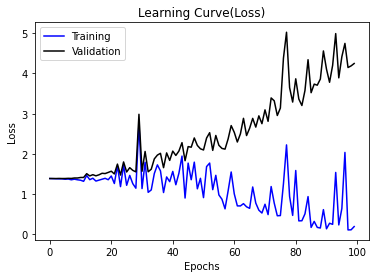

In [57]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='Training')
plt.plot(history[:,0], history[:,3], 'k', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve(Loss)')
plt.legend()
plt.show()

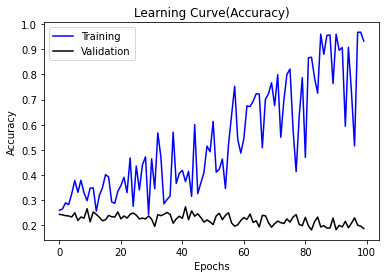

In [58]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='Training')
plt.plot(history[:,0], history[:,4], 'k', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve(Accuracy)')
plt.legend()
plt.show()

In [59]:
test_imgs = [] # 画像イメージを入れる箱

In [60]:
# フォルダ内のファイルの個数を返す
DIR = './test/'
print(sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR)))
image_sum = sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR))

312


In [61]:
str(0).zfill(4)  # ファイル名は4桁の数字 0001 etc.

'0000'

In [62]:
for i in range(image_sum):
    test_img = cv2.imread(f'{BASE_PATH}/test/test_{str(i).zfill(4)}.jpg')
    test_imgs.append(test_img)

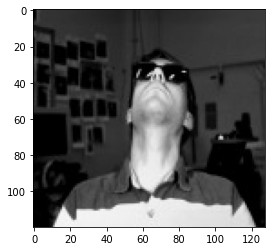

In [63]:
#cv2_imshow(test_imgs[3])
plt.imshow(test_imgs[0])

In [64]:
test_imgs[0].shape # OpenCVのフォーマットは Height, Width, Channel の順. Pytorch は Channel, Height, Weight を期待

(120, 128, 3)

In [65]:
test_imgs[0].transpose(2,0,1).shape

(3, 120, 128)

In [66]:
for i in range(image_sum):
    test_imgs[i] = test_imgs[i].transpose(2,0,1)

In [67]:
test_imgs[2].shape

(3, 120, 128)

In [68]:
X_test = torch.Tensor(test_imgs).float().to(device)

In [69]:
# 保存したモデルを読み込む。
model.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [70]:
y_test = model(X_test)

In [71]:
y_test.shape

torch.Size([312, 4])

In [72]:
# y_test の値を取り出す
predict_y_test = torch.max(y_test, 1)[1]

In [73]:
predict_y_test

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
        1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0,

In [74]:
predicts = predict_y_test.cpu().detach().numpy()

In [75]:
sample_submit = pd.read_csv('./sample_submit.csv', header=None)

In [76]:
sample_submit

,0,1
0,test_0000.jpg,angry
1,test_0001.jpg,angry
2,test_0002.jpg,sad
3,test_0003.jpg,sad
4,test_0004.jpg,sad
...,...,...
307,test_0307.jpg,neutral
308,test_0308.jpg,sad
309,test_0309.jpg,happy
310,test_0310.jpg,sad


In [77]:
for i in range(len(sample_submit)):
    sample_submit.loc[i, 1] = predicts[i]
sample_submit

,0,1
0,test_0000.jpg,0
1,test_0001.jpg,0
2,test_0002.jpg,0
3,test_0003.jpg,0
4,test_0004.jpg,0
...,...,...
307,test_0307.jpg,0
308,test_0308.jpg,0
309,test_0309.jpg,3
310,test_0310.jpg,0


In [78]:
# label-encoding
sample_submit.replace({1:{0:"sad",1:"angry", 2:"neutral", 3:"happy"}}, inplace=True)

In [79]:
sample_submit.to_csv('./submit.csv', index=False, header=False)

In [80]:
#sample_submit.to_csv(‘submit.csv’, index=False, header=False)
#!signate submit --competition-id=404 submit.csv